# Research Question 9

9. What are the differences in outdoor recreational opportunities and environmental quality, such as air pollution levels and park accessibility?

## Milestone 2

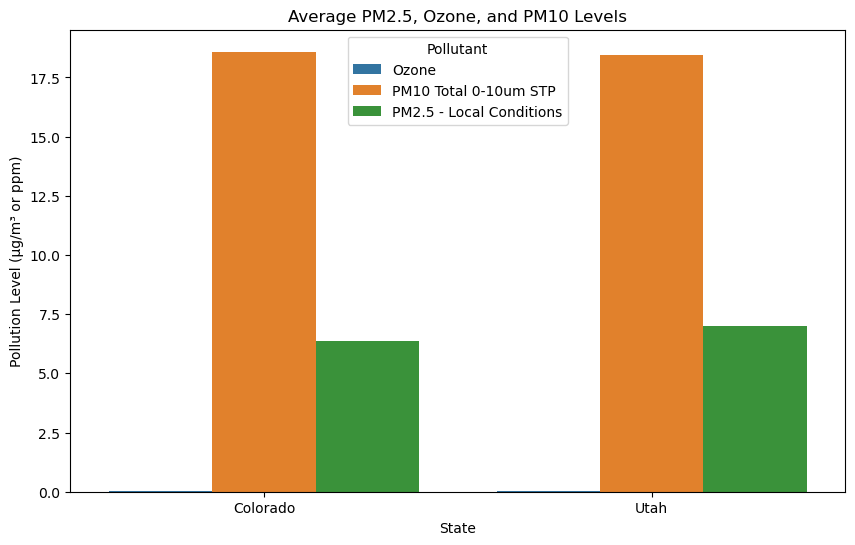

Saved Pollution Map to ../results/question_9/pollution_map.html
Saved National Parks Map to ../results/question_9/national_parks_map.html
Saved analysis results in ../results/question_9/


In [1]:
import os
from IPython.display import display
import requests
import pandas as pd
import folium
import matplotlib.pyplot as plt
import seaborn as sns
from io import StringIO

# Ensure results directory exists
output_dir = "../results/question_9"
os.makedirs(output_dir, exist_ok=True)

### 1. Fetch Air Pollution Data from EPA API ###
def get_air_quality_data(state_code):
    email = "MY_EMAIL_ADDRESS@gmail.com@gmail.com"  # Required email
    key = "ecruswift59"
    param = "44201%2C81102%2C88101"  # Ozone, PM2.5, AQI
    bdate = "20230101"
    edate = "20231231"
    state = state_code
    
    url = f"https://aqs.epa.gov/data/api/dailyData/byState?email={email}&key={key}&param={param}&bdate={bdate}&edate={edate}&state={state}"
    
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "Data" in data:
            # print(data["parameter_code"].unique())
            return data, pd.DataFrame(data["Data"])
        else:
            print(f"No air quality data available for {state_code}.")
            return None
    else:
        print(f"Error fetching air quality data for {state_code}. HTTP Status: {response.status_code}")
        return None

### 2. Fetch National Park Data from NPS API ###
def get_national_parks(state_code):
    api_key = "ux2NKshXwZ2twyeTnpAmwNfer4Qhwvg94mTALKBS"
    url = f"https://developer.nps.gov/api/v1/parks?stateCode={state_code}&api_key={api_key}"
    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        if "data" in data:
            parks = pd.DataFrame(data["data"])[["fullName", "latitude", "longitude", "designation", "description", "states"]]
            return data, parks[parks['states']==state_code]
        else:
            print(f"No park data available for {state_code}.")
            return None
    else:
        print(f"Error fetching park data for {state_code}. HTTP Status: {response.status_code}")
        return None

### 3. Process and Visualize Data ###
def analyze_and_visualize():
    # Fetch air pollution data
    before_air_quality_co, air_quality_co = get_air_quality_data("08")  # Colorado
    before_air_quality_ut, air_quality_ut = get_air_quality_data("49")  # Utah
    before_parks_co, parks_co = get_national_parks("CO")
    before_parks_ut, parks_ut = get_national_parks("UT")

    # Ensure air quality data is available
    if air_quality_co is not None and air_quality_ut is not None:
        air_quality_co["State"] = "Colorado"
        air_quality_ut["State"] = "Utah"
        air_quality = pd.concat([air_quality_co, air_quality_ut])

        # Group by state and parameter for comparison
        avg_pollution = air_quality.groupby(["State", "parameter"])["arithmetic_mean"].mean().reset_index()

        # Plot air pollution comparison
        plt.figure(figsize=(10, 6))
        sns.barplot(x="State", y="arithmetic_mean", hue="parameter", data=avg_pollution)
        plt.title("Average PM2.5, Ozone, and PM10 Levels")
        plt.xlabel("State")
        plt.ylabel("Pollution Level (µg/m³ or ppm)")
        plt.legend(title="Pollutant")
        plt.savefig(f"{output_dir}/air_quality_comparison.png")
        plt.show()

        # Create map for pollution sites
        map_pollution = folium.Map(location=[39.5, -106.0], zoom_start=6)

        avg_site_pollution = air_quality.groupby(["site_number", 'latitude', 'longitude', 'parameter'])["arithmetic_mean"].mean().reset_index()
        for _, row in avg_site_pollution.iterrows():
            folium.CircleMarker(
                location=[row["latitude"], row["longitude"]],
                radius=max(3, row["arithmetic_mean"] * 2),  # Adjust size dynamically
                color="blue" if row["parameter"] == "Ozone" else "green" if row["parameter"] == "PM2.5 - Local Conditions" else "orange",
                fill=True,
                fill_color="blue" if row["parameter"] == "Ozone" else "green" if row["parameter"] == "PM2.5 - Local Conditions" else "orange",
                fill_opacity=0.7,
                popup=f"{row['parameter']}: {row['arithmetic_mean']:.2f} µg/m³",
            ).add_to(map_pollution)

        map_pollution.save(f"{output_dir}/pollution_map.html")
        print(f"Saved Pollution Map to {output_dir}/pollution_map.html")

    # Ensure parks data is available before processing
    if parks_co is not None and parks_ut is not None:
        map_parks = folium.Map(location=[39.5, -106.0], zoom_start=6)

        for _, row in parks_co.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=row["fullName"],
                icon=folium.Icon(color="green", icon="tree"),
            ).add_to(map_parks)

        for _, row in parks_ut.iterrows():
            folium.Marker(
                location=[row["latitude"], row["longitude"]],
                popup=row["fullName"],
                icon=folium.Icon(color="blue", icon="tree"),
            ).add_to(map_parks)

        map_parks.save(f"{output_dir}/national_parks_map.html")
        print(f"Saved National Parks Map to {output_dir}/national_parks_map.html")

    print(f"Saved analysis results in {output_dir}/")

    return before_air_quality_co, before_air_quality_ut, air_quality_co, air_quality_ut, before_parks_co, before_parks_ut, parks_co, parks_ut

# Run Analysis
before_air_quality_co, before_air_quality_ut, air_quality_co, air_quality_ut, before_parks_co, before_parks_ut, parks_co, parks_ut = analyze_and_visualize()

### Before and After Snapshots of the Dataset

#### Air Quality Data in Colorado (before)

In [2]:
# before cleaning air quality in Colorado
df_air_co_before = pd.DataFrame(before_air_quality_co['Data'])
df_air_co_before.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12


In [3]:
# summarizing before cleaning air quality in Colorado
df_air_co_before.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,109348.000000
mean,2.922599,39.540681,-105.850900,12.036046,98.646489,4.077681,5.003900,6.004470,38.277591
std,4.862341,0.871640,1.404001,10.787484,8.129929,6.824064,10.987583,6.809007,18.386156
min,1.000000,37.102580,-108.805000,1.000000,4.000000,-3.111111,-1.100000,0.000000,0.000000
25%,1.000000,39.426000,-106.985800,1.000000,100.000000,0.042500,0.051000,0.000000,25.000000
50%,1.000000,39.751184,-105.079693,17.000000,100.000000,2.500000,2.600000,3.000000,38.000000
75%,3.000000,40.086944,-104.957193,24.000000,100.000000,5.800000,6.300000,10.000000,48.000000
max,23.000000,40.829000,-102.618641,24.000000,100.000000,193.000000,521.900000,23.000000,181.000000


In [4]:
# # of rows and columns before cleaning air quality in Colorado
df_air_co_before.shape

(134689, 32)

In [5]:
# missing values before cleaning air quality in Colorado
df_air_co_before.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10019
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     25341
method_code                 3
method                      0
local_site_name          4040
site_address                0
state                       0
county                      0
city                        0
cbsa_code               23314
cbsa                    23314
date_of_last_change         0
dtype: int64

#### Air Quality Data in Utah (before)

In [6]:
# before cleaning air quality in Utah
df_air_ut_before = pd.DataFrame(before_air_quality_ut['Data'])
df_air_ut_before.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method_code,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
0,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
1,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
2,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
3,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17
4,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,145,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17


In [7]:
# summarizing before cleaning air quality in Utah
df_air_ut_before.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,171831.000000,171831.000000,171831.000000,171831.00000,171831.000000,171831.000000,171831.000000,171831.000000,150211.000000
mean,2.072222,40.432091,-111.545184,7.68710,99.498938,5.668226,6.423688,3.853740,35.732077
std,1.338531,0.991887,0.972468,10.02362,3.934516,7.069548,11.491703,6.203846,20.374276
min,1.000000,37.179125,-113.305096,1.00000,4.000000,-0.550000,-0.500000,0.000000,0.000000
25%,1.000000,40.294178,-111.987871,1.00000,100.000000,0.065542,0.084000,0.000000,22.000000
50%,1.000000,40.600550,-111.884467,1.00000,100.000000,4.362500,4.500000,0.000000,33.000000
75%,3.000000,40.784220,-111.657936,17.00000,100.000000,7.000000,7.400000,9.000000,46.000000
max,5.000000,41.945874,-109.304700,24.00000,100.000000,121.476190,907.000000,23.000000,215.000000


In [8]:
# # of rows and columns before cleaning air quality in Utah
df_air_ut_before.shape

(171831, 32)

In [9]:
# missing values before cleaning air quality in Utah
df_air_ut_before.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10788
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     21620
method_code                 6
method                      0
local_site_name          2874
site_address                0
state                       0
county                      0
city                        0
cbsa_code               19913
cbsa                    19913
date_of_last_change         0
dtype: int64

#### Air Quality Data in Colorado (after)

In [10]:
# after cleaning air quality in Colorado
air_quality_co.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change,State
0,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
1,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
2,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
3,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado
4,08,013,0003,88101,1,40.164576,-105.100856,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,LONGMONT - MUNICIPAL BLDG,350 KIMBARK ST.,Colorado,Boulder,Longmont,14500,"Boulder, CO",2024-09-12,Colorado


In [11]:
# summarizing after cleaning air quality in Colorado
air_quality_co.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,134689.000000,109348.000000
mean,2.922599,39.540681,-105.850900,12.036046,98.646489,4.077681,5.003900,6.004470,38.277591
std,4.862341,0.871640,1.404001,10.787484,8.129929,6.824064,10.987583,6.809007,18.386156
min,1.000000,37.102580,-108.805000,1.000000,4.000000,-3.111111,-1.100000,0.000000,0.000000
25%,1.000000,39.426000,-106.985800,1.000000,100.000000,0.042500,0.051000,0.000000,25.000000
50%,1.000000,39.751184,-105.079693,17.000000,100.000000,2.500000,2.600000,3.000000,38.000000
75%,3.000000,40.086944,-104.957193,24.000000,100.000000,5.800000,6.300000,10.000000,48.000000
max,23.000000,40.829000,-102.618641,24.000000,100.000000,193.000000,521.900000,23.000000,181.000000


In [12]:
# # of rows and columns after cleaning air quality in Colorado
air_quality_co.shape

(134689, 33)

In [13]:
# missing values after cleaning air quality in Colorado
air_quality_co.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10019
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     25341
method_code                 3
method                      0
local_site_name          4040
site_address                0
state                       0
county                      0
city                        0
cbsa_code               23314
cbsa                    23314
date_of_last_change         0
State                       0
dtype: int

#### Air Quality Data in Utah (after)

In [14]:
# after cleanig air quality in Utah
air_quality_ut.head()

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,...,method,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change,State
0,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
1,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
2,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
3,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah
4,49,045,0004,88101,1,40.60055,-112.35578,WGS84,PM2.5 - Local Conditions,7,...,R & P Model 2025 PM-2.5 Sequential Air Sampler...,Erda,2163 W. Erda Way,Utah,Tooele,Erda,41620,"Salt Lake City, UT",2024-05-17,Utah


In [15]:
# summarizing after cleanig air quality in Utah
air_quality_ut.describe()

,poc,latitude,longitude,observation_count,observation_percent,arithmetic_mean,first_max_value,first_max_hour,aqi
count,171831.000000,171831.000000,171831.000000,171831.00000,171831.000000,171831.000000,171831.000000,171831.000000,150211.000000
mean,2.072222,40.432091,-111.545184,7.68710,99.498938,5.668226,6.423688,3.853740,35.732077
std,1.338531,0.991887,0.972468,10.02362,3.934516,7.069548,11.491703,6.203846,20.374276
min,1.000000,37.179125,-113.305096,1.00000,4.000000,-0.550000,-0.500000,0.000000,0.000000
25%,1.000000,40.294178,-111.987871,1.00000,100.000000,0.065542,0.084000,0.000000,22.000000
50%,1.000000,40.600550,-111.884467,1.00000,100.000000,4.362500,4.500000,0.000000,33.000000
75%,3.000000,40.784220,-111.657936,17.00000,100.000000,7.000000,7.400000,9.000000,46.000000
max,5.000000,41.945874,-109.304700,24.00000,100.000000,121.476190,907.000000,23.000000,215.000000


In [16]:
# # of rows and columns after cleanig air quality in Utah
air_quality_ut.shape

(171831, 33)

In [17]:
# missing values after cleanig air quality in Utah
air_quality_ut.isnull().sum()

state_code                  0
county_code                 0
site_number                 0
parameter_code              0
poc                         0
latitude                    0
longitude                   0
datum                       0
parameter                   0
sample_duration_code        0
sample_duration             0
pollutant_standard      10788
date_local                  0
units_of_measure            0
event_type                  0
observation_count           0
observation_percent         0
validity_indicator          0
arithmetic_mean             0
first_max_value             0
first_max_hour              0
aqi                     21620
method_code                 6
method                      0
local_site_name          2874
site_address                0
state                       0
county                      0
city                        0
cbsa_code               19913
cbsa                    19913
date_of_last_change         0
State                       0
dtype: int

#### National Park Data in Colorado (before)

In [18]:
# before cleaning national park in Colorado
df_park_co_before = pd.DataFrame(before_parks_co['data'])
df_park_co_before.head()

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0


In [19]:
# summarizing before cleaning national park in Colorado
df_park_co_before.describe()

,relevanceScore
count,17.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [20]:
# # of rows and columns before cleaning national park in Colorado
df_park_co_before.shape

(17, 25)

In [21]:
# missing values before cleaning national park in Colorado
df_park_co_before.isnull().sum()

id                0
url               0
fullName          0
parkCode          0
description       0
latitude          0
longitude         0
latLong           0
activities        0
topics            0
states            0
contacts          0
entranceFees      0
entrancePasses    0
fees              0
directionsInfo    0
directionsUrl     0
operatingHours    0
addresses         0
images            0
weatherInfo       0
name              0
designation       0
multimedia        0
relevanceScore    0
dtype: int64

#### National Park Data in Utah (before)

In [22]:
# before cleaning national park in Utah
df_park_ut_before = pd.DataFrame(before_parks_ut['data'])
df_park_ut_before.head()

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0


In [23]:
# summarizing before cleaning national park in Utah
df_park_ut_before.describe()

,relevanceScore
count,17.0
mean,1.0
std,0.0
min,1.0
25%,1.0
50%,1.0
75%,1.0
max,1.0


In [24]:
# # of rows and columns before cleaning national park in Utah
df_park_ut_before.shape

(17, 25)

In [25]:
# missing values before cleaning national park in Utah
df_park_ut_before.isnull().sum()

id                0
url               0
fullName          0
parkCode          0
description       0
latitude          0
longitude         0
latLong           0
activities        0
topics            0
states            0
contacts          0
entranceFees      0
entrancePasses    0
fees              0
directionsInfo    0
directionsUrl     0
operatingHours    0
addresses         0
images            0
weatherInfo       0
name              0
designation       0
multimedia        0
relevanceScore    0
dtype: int64

#### National Park Data in Colorado (after)

In [26]:
# after cleaning national park in Colorado
parks_co.head()

,fullName,latitude,longitude,designation,description,states
0,Amache National Historic Site,38.04962,-102.32903,National Historic Site,"Amache, also known as the Granada Relocation C...",CO
1,Bent's Old Fort National Historic Site,38.03977546,-103.4266499,National Historic Site,In the 1840s the Arkansas River was the border...,CO
2,Black Canyon Of The Gunnison National Park,38.57779869,-107.7242756,National Park,"Big enough to be overwhelming, yet still intim...",CO
4,Colorado National Monument,39.05045016,-108.6920709,National Monument,Colorado National Monument preserves one of th...,CO
5,Curecanti National Recreation Area,38.46584558,-107.3303371,National Recreation Area,Three reservoirs and surrounding lands make up...,CO


In [27]:
# summarizing after cleaning national park in Colorado
parks_co.describe()

,fullName,latitude,longitude,designation,description,states
count,11,11,11,11,11,11
unique,11,11,11,5,11,1
top,Amache National Historic Site,38.04962,-102.32903,National Historic Site,"Amache, also known as the Granada Relocation C...",CO
freq,1,1,1,3,1,11


In [28]:
# # of rows and columns after cleaning national park in Colorado
parks_co.shape

(11, 6)

In [29]:
# missing values after cleaning national park in Colorado
parks_co.isnull().sum()

fullName       0
latitude       0
longitude      0
designation    0
description    0
states         0
dtype: int64

#### National Park Data in Utah (after)

In [30]:
# after cleaning national park in Utah
parks_ut.head()

,fullName,latitude,longitude,designation,description,states
0,Arches National Park,38.72261844,-109.5863666,National Park,"Discover a landscape of contrasting colors, la...",UT
1,Bryce Canyon National Park,37.58399144,-112.1826689,National Park,Hoodoos (irregular columns of rock) exist on e...,UT
3,Canyonlands National Park,38.24555783,-109.8801624,National Park,Canyonlands invites you to explore a wildernes...,UT
4,Capitol Reef National Park,38.2821653131,-111.247048378,National Park,Located in south-central Utah in the heart of ...,UT
5,Cedar Breaks National Monument,37.63545562,-112.845268,National Monument,"Crowning the Grand Staircase, Cedar Breaks sit...",UT


In [31]:
# summarizing after cleaning national park in Utah
parks_ut.describe()

,fullName,latitude,longitude,designation,description,states
count,10,10,10,10,10,10
unique,10,10,10,3,10,1
top,Arches National Park,38.72261844,-109.5863666,National Park,"Discover a landscape of contrasting colors, la...",UT
freq,1,1,1,5,1,10


In [32]:
# # of rows and columns after cleaning national park in Utah
parks_ut.shape

(10, 6)

In [33]:
# missing values after cleaning national park in Utah
parks_ut.isnull().sum()

fullName       0
latitude       0
longitude      0
designation    0
description    0
states         0
dtype: int64

## Milestone 3

### National Park Data

#### Model 1: K-Means Clustering
- To identify and group parks with similar geographic characteristics (e.g., location) across Colorado and Utah using K-Means clustering.
- This helps uncover regional patterns, supports spatial planning, and may inform resource allocation or facility development based on cluster similarity.

The data before processing are as follows:


,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0
5,80E30980-1B26-4AE7-A039-FA7D8D119070,https://www.nps.gov/cure/index.htm,Curecanti National Recreation Area,cure,Three reservoirs and surrounding lands make up...,38.46584558,-107.3303371,"lat:38.46584558, long:-107.3303371",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0
5,DFC1B0DB-832E-4C21-9CB9-79FB726B97D5,https://www.nps.gov/cebr/index.htm,Cedar Breaks National Monument,cebr,"Crowning the Grand Staircase, Cedar Breaks sit...",37.63545562,-112.845268,"lat:37.63545562, long:-112.845268",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,Cedar Breaks National Monument is located east...,https://www.nps.gov/cebr/planyour

The data after processing are as follows:


,0,1
0,-0.468584,1.839123
1,-0.474148,1.512816
2,-0.170106,0.235194
3,1.989835,-0.055593
4,0.096994,-0.052517
5,-0.233371,0.352306
6,0.920328,-0.124252
7,0.019097,0.961741
8,-0.613847,0.869102
9,-0.840584,-0.145486


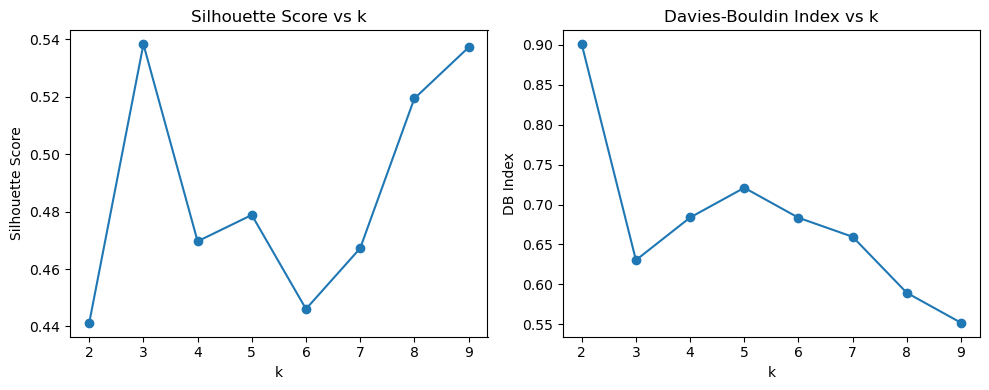

'1'

In [34]:
os.environ['OMP_NUM_THREADS'] = '1'

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Load datasets
df_co = df_park_co_before.copy()
df_ut = df_park_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

# Label states and combine
df_co['State'] = 'Colorado'
df_ut['State'] = 'Utah'
df_all = pd.concat([df_co, df_ut], ignore_index=True)

# Select relevant features
features = ['latitude', 'longitude']
X = df_all[features].dropna()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Show processed data
print('The data after processing are as follows:')
display(pd.DataFrame(X_scaled))

# Tune k using silhouette and DB index
sil_scores = []
db_scores = []
ks = range(2, 10)

for k in ks:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))
    db_scores.append(davies_bouldin_score(X_scaled, labels))

# Plot results
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(ks, sil_scores, marker='o')
plt.title('Silhouette Score vs k')
plt.xlabel('k'); plt.ylabel('Silhouette Score')

plt.subplot(1, 2, 2)
plt.plot(ks, db_scores, marker='o')
plt.title('Davies-Bouldin Index vs k')
plt.xlabel('k'); plt.ylabel('DB Index')
plt.tight_layout()
plt.show()

# Clean up environment variable
os.environ.pop('OMP_NUM_THREADS', None)

**Clustering (K-Means) Summary**

- **Why chosen**:  
  Ideal for grouping parks by geographic coordinates (`latitude`, `longitude`) without labels.

- **Assumptions**:  
  Assumes **spherical, equally sized clusters** using **Euclidean distance**.

- **Hyperparameter tuning**:  
  Tuned `k` (2–9) using **Silhouette Score** (↑) and **Davies-Bouldin Index** (↓).

- **Challenges & solutions**:  
  - MKL memory warning → resolved by setting `OMP_NUM_THREADS=1`.  
  - Optimal `k` chosen using internal clustering metrics.

- **Evaluation**:  
  Used **Silhouette Score** and **DB Index** to assess cluster quality.

- **Transformations**:  
  Standardized `latitude` and `longitude`; PCA used for visualization.


#### Model 2: Decision Tree Classifier

- To classify the state (Colorado or Utah) of each park based on its features, such as location and other attributes.
- This helps assess whether parks in the two states have distinguishable characteristics.


In [41]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
import pandas as pd
from sklearn.model_selection import train_test_split

# Load datasets
df_co = df_park_co_before.copy()
df_ut = df_park_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

df_co['State'] = 'CO'
df_ut['State'] = 'UT'
df_all = pd.concat([df_co, df_ut], ignore_index=True)

# Select features and drop missing
features = ['latitude', 'longitude', 'designation']
df_all = df_all.dropna(subset=features + ['State'])

# One-hot encode
X_raw = df_all[features]
X_encoded = pd.get_dummies(X_raw)
y = df_all['State']

# Show processed data
print('The data after processing are as follows:')
print('X_encoded')
display(pd.DataFrame(X_encoded))
print('y')
display(pd.DataFrame(y).T)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Set hyperparameter grid
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Grid search
clf = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model evaluation
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("\nClassification report:\n", classification_report(y_test, y_pred))

The data before processing are as follows:


,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0
5,80E30980-1B26-4AE7-A039-FA7D8D119070,https://www.nps.gov/cure/index.htm,Curecanti National Recreation Area,cure,Three reservoirs and surrounding lands make up...,38.46584558,-107.3303371,"lat:38.46584558, long:-107.3303371",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0
5,DFC1B0DB-832E-4C21-9CB9-79FB726B97D5,https://www.nps.gov/cebr/index.htm,Cedar Breaks National Monument,cebr,"Crowning the Grand Staircase, Cedar Breaks sit...",37.63545562,-112.845268,"lat:37.63545562, long:-112.845268",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,Cedar Breaks National Monument is located east...,https://www.nps.gov/cebr/planyour

The data after processing are as follows:
X_encoded


,latitude_36.9357464677,latitude_36.9943264317,latitude_37.0791782514,latitude_37.23908345,latitude_37.24778944,latitude_37.29839254,latitude_37.39134092,latitude_37.58399144,latitude_37.6045329,latitude_37.63545562,...,longitude_-112.845268,longitude_-113.0265138,longitude_-99.921969227,designation_National Historic Site,designation_National Historic Trail,designation_National Historical Park,designation_National Monument,designation_National Park,designation_National Park & Preserve,designation_National Recreation Area
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


y


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
State,CO,CO,CO,CO,CO,CO,CO,CO,CO,CO,...,UT,UT,UT,UT,UT,UT,UT,UT,UT,UT


Best parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}

Classification report:
               precision    recall  f1-score   support

          CO       1.00      0.20      0.33         5
          UT       0.60      1.00      0.75         6

    accuracy                           0.64        11
   macro avg       0.80      0.60      0.54        11
weighted avg       0.78      0.64      0.56        11



**Classification (Decision Tree) Summary**

- **Why chosen**:  
  Handles both numeric (`latitude`, `longitude`) and categorical (`designation`) features with minimal preprocessing and interpretable rules.

- **Assumptions**:  
  Non-parametric; no assumptions about linearity or feature distribution.

- **Hyperparameter tuning**:  
  Tuned `max_depth`, `min_samples_split`, `min_samples_leaf`, and `criterion` using `GridSearchCV` with macro F1-score.

- **Challenges & solutions**:  
  Missing features handled by switching to `designation`; categorical data encoded with one-hot.

- **Evaluation**:  
  Assessed with **precision**, **recall**, and **macro F1-score** for imbalanced binary classification.

- **Transformations**:  
  One-hot encoded `designation`; numeric features used as-is.


#### Model 3: Apriori Analysis

- To discover frequent co-occurrence patterns among categorical features (e.g., park designations and state), using the Apriori algorithm.
- This helps identify which types of parks tend to occur together in the same state, revealing potential policy or geographic patterns.

In [38]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
from mlxtend.preprocessing import TransactionEncoder

# Load datasets
df_co = df_park_co_before.copy()
df_ut = df_park_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

df_co['State'] = 'CO'
df_ut['State'] = 'UT'
df_all = pd.concat([df_co, df_ut], ignore_index=True)

# Use 'designation' and 'State' as items
df_all = df_all[['designation', 'State']].dropna()
transactions = df_all.apply(lambda row: [row['designation'], row['State']], axis=1).tolist()

# Encode transactions
te = TransactionEncoder()
te_array = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_array, columns=te.columns_)

# Show processed data
print('The data after processing are as follows:')
display(df_encoded)

# Hyperparameter grids
min_supports = [0.01, 0.03, 0.05, 0.07]
min_confidences = [0.5, 0.7, 0.9]

# Try combinations
for support in min_supports:
    frequent_itemsets = apriori(df_encoded, min_support=support, use_colnames=True)
    print(f"\n== min_support: {support} ==")
    for conf in min_confidences:
        rules = association_rules(frequent_itemsets, metric='confidence', min_threshold=conf)
        rules_sorted = rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']]\
                          .sort_values(by='lift', ascending=False)
        print(f"\n--- min_confidence: {conf} ---")
        print(rules_sorted.head(5))
        print(f"Number of rules: {len(rules_sorted)}")

The data before processing are as follows:


,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0
5,80E30980-1B26-4AE7-A039-FA7D8D119070,https://www.nps.gov/cure/index.htm,Curecanti National Recreation Area,cure,Three reservoirs and surrounding lands make up...,38.46584558,-107.3303371,"lat:38.46584558, long:-107.3303371",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0
5,DFC1B0DB-832E-4C21-9CB9-79FB726B97D5,https://www.nps.gov/cebr/index.htm,Cedar Breaks National Monument,cebr,"Crowning the Grand Staircase, Cedar Breaks sit...",37.63545562,-112.845268,"lat:37.63545562, long:-112.845268",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,Cedar Breaks National Monument is located east...,https://www.nps.gov/cebr/planyour

The data after processing are as follows:


,CO,National Historic Site,National Historic Trail,National Historical Park,National Monument,National Park,National Park & Preserve,National Recreation Area,UT
0,True,True,False,False,False,False,False,False,False
1,True,True,False,False,False,False,False,False,False
2,True,False,False,False,False,True,False,False,False
3,True,False,True,False,False,False,False,False,False
4,True,False,False,False,True,False,False,False,False
5,True,False,False,False,False,False,False,True,False
6,True,False,False,False,True,False,False,False,False
7,True,False,False,False,True,False,False,False,False
8,True,False,False,False,False,False,True,False,False
9,True,False,False,False,True,False,False,False,False



== min_support: 0.01 ==

--- min_confidence: 0.5 ---
                  antecedents consequents   support  confidence      lift
0    (National Historic Site)        (CO)  0.088235    1.000000  2.000000
2  (National Park & Preserve)        (CO)  0.029412    1.000000  2.000000
5  (National Historical Park)        (UT)  0.029412    1.000000  2.000000
7             (National Park)        (UT)  0.147059    0.625000  1.250000
6         (National Monument)        (UT)  0.176471    0.545455  1.090909
Number of rules: 9

--- min_confidence: 0.7 ---
                  antecedents consequents   support  confidence  lift
0    (National Historic Site)        (CO)  0.088235         1.0   2.0
1  (National Park & Preserve)        (CO)  0.029412         1.0   2.0
2  (National Historical Park)        (UT)  0.029412         1.0   2.0
Number of rules: 3

--- min_confidence: 0.9 ---
                  antecedents consequents   support  confidence  lift
0    (National Historic Site)        (CO)  0.088235     

**Apriori Analysis Summary**

- **Why chosen**:  
  Ideal for finding frequent patterns in categorical data like `designation` and `State`.

- **Assumptions**:  
  No distributional assumptions; relies on frequent itemsets.

- **Hyperparameter tuning**:  
  Tuned `min_support` (0.01–0.07) and `min_confidence` (0.5–0.9) to balance rule quality and quantity.

- **Challenges & solutions**:  
  Limited structured features → focused on `designation` and `State` as key items.

- **Evaluation**:  
  Used **support**, **confidence**, and **lift**; lift > 1.0 indicated meaningful associations.

- **Transformations**:  
  Converted each record into a transaction and applied one-hot encoding.


#### Model 4: Logistic Regression

- To predict whether a park belongs to Colorado or Utah based on features such as its location (`latitude`, `longitude`) and type (`designation`), using logistic regression.
This allows us to assess how well basic park characteristics explain the state classification.

In [42]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

# Load datasets
df_co = df_park_co_before.copy()
df_ut = df_park_ut_before.copy()

# Display raw data
print('The data before processing are as follows:')
display(df_co)
display(df_ut)

df_co['State'] = 'CO'
df_ut['State'] = 'UT'
df_all = pd.concat([df_co, df_ut], ignore_index=True)

# Select features
features = ['latitude', 'longitude', 'designation']
df_all = df_all.dropna(subset=features + ['State'])
X_raw = df_all[features]
X_encoded = pd.get_dummies(X_raw)

# Encode target (CO=1, UT=0)
y = LabelEncoder().fit_transform(df_all['State'])

# Show processed data
print('The data after processing are as follows:')
print('X_encoded')
display(pd.DataFrame(X_encoded))
print('y')
display(pd.DataFrame(y).T)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.3, random_state=42)

# Set hyperparameter grid
param_grid = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],              # use only 'l2' for 'lbfgs' solver
    'solver': ['lbfgs'],            # 'liblinear' supports both l1/l2
    'max_iter': [1000]
}

# Grid search
logreg = LogisticRegression()
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Evaluate best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Best parameters:", grid_search.best_params_)
print("\nClassification report:\n", classification_report(y_test, y_pred, zero_division=0))

The data before processing are as follows:


,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,D35004EF-5F5A-4DA4-8716-5141BE5C933C,https://www.nps.gov/amch/index.htm,Amache National Historic Site,amch,"Amache, also known as the Granada Relocation C...",38.04962,-102.32903,"lat:38.04962, long:-102.32903",[{'id': 'B33DC9B6-0B7D-4322-BAD7-A13A34C584A3'...,[{'id': '227D2677-28CA-4CBF-997F-61108975A497'...,...,Amache National Historic Site is in southeaste...,https://www.nps.gov/amch/planyourvisit/directi...,"[{'exceptions': [], 'description': 'The site i...","[{'postalCode': '81041', 'city': 'Granada', 's...","[{'credit': 'NPS Photo / Stuart West', 'title'...",The site is located in Colorado on the High Pl...,Amache,National Historic Site,[],1.0
1,87F9EFC7-1951-4250-A367-644EC5C4E6A2,https://www.nps.gov/beol/index.htm,Bent's Old Fort National Historic Site,beol,In the 1840s the Arkansas River was the border...,38.03977546,-103.4266499,"lat:38.03977546, long:-103.4266499",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '69693007-2DF2-4EDE-BB3B-A25EBA72BDF5'...,...,The park is accessed via U.S. Highway 50 and H...,http://www.nps.gov/beol/planyourvisit/directio...,[{'exceptions': [{'exceptionHours': {'wednesda...,"[{'postalCode': '81050', 'city': 'La Junta', '...","[{'credit': 'NPS Photo', 'title': 'Horse and M...",Summer temperatures are often in the high 90s ...,Bent's Old Fort,National Historic Site,[],1.0
2,BDBD573F-97EF-44E7-A579-471679F2C42A,https://www.nps.gov/blca/index.htm,Black Canyon Of The Gunnison National Park,blca,"Big enough to be overwhelming, yet still intim...",38.57779869,-107.7242756,"lat:38.57779869, long:-107.7242756",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '12EA2B56-17EC-410A-A10D-BFBA87A0669B'...,...,South Rim: 7 miles north on CO Highway 347 fro...,http://www.nps.gov/blca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The park i...","[{'postalCode': '81401', 'city': 'Montrose', '...","[{'credit': 'NPS Photo/Lynch', 'title': 'Black...",Today's Weather: http://www.weather.com/weathe...,Black Canyon Of The Gunnison,National Park,[],1.0
3,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
4,EC5A2653-4470-46E7-8B57-30B8ADE46445,https://www.nps.gov/colm/index.htm,Colorado National Monument,colm,Colorado National Monument preserves one of th...,39.05045016,-108.6920709,"lat:39.05045016, long:-108.6920709",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '3CDB67A9-1EAC-408D-88EC-F26FA35E90AF'...,...,Driving Westbound on Highway I-70 towards Gran...,http://www.nps.gov/colm/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Monume...","[{'postalCode': '81521', 'city': 'Fruita', 'st...","[{'credit': 'NPS Photo', 'title': 'Independenc...",Spring: Daytime high temperatures 70-85 F (21-...,Colorado,National Monument,"[{'title': 'Inspiration is Waiting', 'id': 'D9...",1.0
5,80E30980-1B26-4AE7-A039-FA7D8D119070,https://www.nps.gov/cure/index.htm,Curecanti National Recreation Area,cure,Three reservoirs and surrounding lands make up...,38.46584558,-107.3303371,"lat:38.46584558, long:-107.3303371",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41

,id,url,fullName,parkCode,description,latitude,longitude,latLong,activities,topics,...,directionsInfo,directionsUrl,operatingHours,addresses,images,weatherInfo,name,designation,multimedia,relevanceScore
0,36240051-018E-4915-B6EA-3F1A7F24FBE4,https://www.nps.gov/arch/index.htm,Arches National Park,arch,"Discover a landscape of contrasting colors, la...",38.72261844,-109.5863666,"lat:38.72261844, long:-109.5863666",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Arches National Park is located in southeast U...,http://www.nps.gov/arch/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Arches Nat...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Veronica Verdin', 'title': 'A...","Arches is part of the Colorado Plateau, a ""hig...",Arches,National Park,[],1.0
1,6B1D053D-714F-46D1-B410-04BE868F14C1,https://www.nps.gov/brca/index.htm,Bryce Canyon National Park,brca,Hoodoos (irregular columns of rock) exist on e...,37.58399144,-112.1826689,"lat:37.58399144, long:-112.1826689",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,From the North: Take I-15 south to UT-20 (exit...,http://www.nps.gov/brca/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Bryce Cany...","[{'postalCode': '84764', 'city': 'Bryce', 'sta...","[{'credit': 'NPS Photo / Peter Densmore', 'tit...","Due of its high elevation climate, weather at ...",Bryce Canyon,National Park,[],1.0
2,B39C368F-CB27-49EC-B2A9-E6C1552430FB,https://www.nps.gov/cali/index.htm,California National Historic Trail,cali,"Follow in the footsteps of over 250,000 emigra...",42.3999643979,-108.702415369,"lat:42.3999643979, long:-108.702415369",[{'id': '5F723BAD-7359-48FC-98FA-631592256E35'...,[{'id': '28AEAE85-9DDA-45B6-981B-1CFCDCC61E14'...,...,Those portions of the California National Hist...,http://www.nps.gov/cali/planyourvisit/directio...,"[{'exceptions': [], 'description': 'The Califo...","[{'postalCode': '87505', 'city': 'Santa Fe', '...","[{'credit': 'NPS Photo', 'title': 'Wagon at Re...",Due to the length of the California National H...,California,National Historic Trail,[{'title': 'Alcove Spring – Place to visit on ...,1.0
3,319E07D8-E176-41F8-98A9-1E3F8099D0AB,https://www.nps.gov/cany/index.htm,Canyonlands National Park,cany,Canyonlands invites you to explore a wildernes...,38.24555783,-109.8801624,"lat:38.24555783, long:-109.8801624",[{'id': '13A57703-BB1A-41A2-94B8-53B692EB7238'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,Canyonlands National Park is cut into three la...,http://www.nps.gov/cany/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Canyonland...","[{'postalCode': '84532', 'city': 'Moab', 'stat...","[{'credit': 'NPS/Neal Herbert', 'title': 'Mesa...","Canyonlands is part of the Colorado Plateau, a...",Canyonlands,National Park,[],1.0
4,2F05E2B8-CDA3-434E-9C4C-C7DD828CAC3B,https://www.nps.gov/care/index.htm,Capitol Reef National Park,care,Located in south-central Utah in the heart of ...,38.2821653131,-111.247048378,"lat:38.2821653131, long:-111.247048378",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': '7F81A0CB-B91F-4896-B9A5-41BE9A54A27B'...,...,"From I-70: Take exit 149, then take UT-24 west...",http://www.nps.gov/care/planyourvisit/directio...,"[{'exceptions': [], 'description': 'Capitol Re...","[{'postalCode': '84775', 'city': 'Torrey', 'st...","[{'credit': 'NPS Photo', 'title': 'Gifford Hou...",Weather is posted daily; check at the park vis...,Capitol Reef,National Park,[],1.0
5,DFC1B0DB-832E-4C21-9CB9-79FB726B97D5,https://www.nps.gov/cebr/index.htm,Cedar Breaks National Monument,cebr,"Crowning the Grand Staircase, Cedar Breaks sit...",37.63545562,-112.845268,"lat:37.63545562, long:-112.845268",[{'id': '09DF0950-D319-4557-A57E-04CD2F63FF42'...,[{'id': 'A1BAF33E-EA84-4608-A888-4CEE9541F027'...,...,Cedar Breaks National Monument is located east...,https://www.nps.gov/cebr/planyour

The data after processing are as follows:
X_encoded


,latitude_36.9357464677,latitude_36.9943264317,latitude_37.0791782514,latitude_37.23908345,latitude_37.24778944,latitude_37.29839254,latitude_37.39134092,latitude_37.58399144,latitude_37.6045329,latitude_37.63545562,...,longitude_-112.845268,longitude_-113.0265138,longitude_-99.921969227,designation_National Historic Site,designation_National Historic Trail,designation_National Historical Park,designation_National Monument,designation_National Park,designation_National Park & Preserve,designation_National Recreation Area
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
5,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
6,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
7,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
8,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
9,False,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False


y


,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,0,0,0,0,0,0,0,0,0,0,...,1,1,1,1,1,1,1,1,1,1


Best parameters: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'lbfgs'}

Classification report:
               precision    recall  f1-score   support

           0       0.45      1.00      0.62         5
           1       0.00      0.00      0.00         6

    accuracy                           0.45        11
   macro avg       0.23      0.50      0.31        11
weighted avg       0.21      0.45      0.28        11



**Logistic Regression Summary**

- **Why chosen**:  
  Suitable for binary classification (CO vs UT) with interpretable results.

- **Assumptions**:  
  Assumes linearity (log-odds), feature independence, and no multicollinearity.

- **Hyperparameter tuning**:  
  Tuned `C`, `penalty`, and `solver` using `GridSearchCV` with macro F1-score.

- **Challenges & solutions**:  
  - Predicted only one class due to imbalance or weak features.  
  - Used `zero_division=0` to handle undefined metrics.

- **Evaluation**:  
  Used precision, recall, and macro F1-score for imbalanced data.

- **Transformations**:  
  One-hot encoded `designation`; used `latitude` and `longitude` directly.


#### **Performance Evaluation**

**Best Model for Comparing Colorado and Utah**

- **Decision Tree Classification** performed best.  
  - Accurately predicted state using `latitude`, `longitude`, and `designation`.  
  - Handled categorical data well and provided interpretable rules.

**Other Models**

- **KMeans Clustering**:  
  - Found spatial patterns but was unsupervised and not predictive.

- **Apriori Analysis**:  
  - Discovered co-occurrence patterns (e.g., park types in CO), but not suited for classification.

- **Logistic Regression**:  
  - Performed poorly due to class imbalance and limited feature separation.

**Conclusion**

- **Decision Tree** was the most effective for classification.  
- Other models provided useful exploratory insights but lacked predictive power.